In [4]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import geopandas
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [6]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Requirements

In [147]:
import sddk
import pandas as pd
pd.options.display.max_columns = 1000 # to see all columns
import json
import geopandas as gpd
import warnings
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

# Import datasets

In [3]:
# read edh dataset
publicfolder = "b6b6afdb969d378b70929e86e58ad975"
EDH = sddk.read_file("EDH_text_cleaned_2021-01-21.json", "df", publicfolder)
EDH.head(5)

reading file located in a public folder


,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,language,id,edh_geography_uri,commentary,trismegistos_uri,not_before,external_image_uris,fotos,coordinates,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,"Marmor, geädert / farbig",tabula,Latium et Campania (Regio I),34 cm,D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,"Cumae, bei",2014-04-07,Campania,"Cuma, bei",Latin,HD000001,https://edh-www.adw.uni-heidelberg.de/edh/geog...,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://www.trismegistos.org/text/251193,0071,{},{},"[14.0551, 40.8472]",251193,"[http://www.trismegistos.org/place/033152, htt...",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,21,unbestimmt,257,Tafel,,"Marmor, geädert / farbig",1000,92,Grabinschrift,epitaph,Certain,33.0,34.0,2.7,Marble,tabula,Certain,Latium et Campania (Regio I),Certain,Italy,Certain,Cumae,Estimated,Campania,Certain,"Cuma, bei",Certain,NULL,NULL,71 AD – 130 AD,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",NaN,marble: rocks - metamorphic rocks,tabula,Roma,85 cm,C(aius) Sextius Paris / qui vixit / annis LXX,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Roma,2014-04-07,Lazio,Roma,Latin,HD000002,https://edh-www.adw.uni-heidelberg.de/edh/geog...,AE 1983: Breite: 35 cm.,https://www.trismegistos.org/text/265631,0051,{},{},"[12.4823, 41.8955]",265631,"[http://www.trismegistos.org/place/000172, htt...",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,21,unbestimmt,257,Tafel,48,Marmor,1000,92,Grabinschrift,epitaph,Certain,28.0,85.0,NaN,Marble,tabula,Certain,Roma,Certain,Italy,Certain,Roma,Certain,Lazio,Certain,Roma,Certain,"Via Nomentana, S. Alessandro, Kirche",Certain,51 AD – 200 AD,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,"Via Nomentana, S. Alessandro, Kirche",1937,NaN,NaN,NaN,NaN,NaN
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,marble: rocks - metamorphic rocks,statue base,Baetica,(34) cm,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,Spain,https://edh-www.adw.uni-heidelberg.de/edh/insc...,NaN,2006-08-31,Sevilla,Tomares,Latin,HD000003,https://edh-www.adw.uni-heidelberg.de/edh/geog...,(B): [S]isenna ist falscher Kasus; folgende E...,https://www.trismegis

In [4]:
# read edcs dataset
publicfolder = "1f5f56d09903fe259c0906add8b3a55e"
EDCS = sddk.read_file("EDCS_text_cleaned_2021-03-01.json", "df", publicfolder)
EDCS.head(5)

reading file located in a public folder


,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,clean_text_interpretive_word,Links,language,dating from,dating to,start_yr,end_yr_1,status,Latitude,Longitude,photo,Material,Comment
0,EDCS-31400030,"CIL 03, 12297",Achaia,Achaia,?,?,{},,{},{},{},{},,,Leius,Leius,Leius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Achaia,Afesou,Afesou,{},,{},{},{},{},,,// D(ecimi) Leivei D(ecimi) Leivei salve,// D(ecimi) Leivei D(ecimi) Leivei salve,Decimi Leivei Decimi Leivei salve,http://db.edcs.eu/epigr/partner.php?s_language...,GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Achaia,Agia Triada / Merbaka / Midea,"[Agia Triada, Merbaka, Midea]",-68,,"[officium/professio, ordo senatorius, tituli h...",tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",{},,,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Quinto Caecilio Cai filio Metello imperatori I...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,-68,-68,-68.0,-68.0,officium/professio; ordo senatorius; tituli ho...,37.6381128,22.8052991,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"[Agios Athanasios, Photike]",313,,"[Augusti/Augustae, litterae erasae, ordo eques...",tituli honorarii,"[Augusti/Augustae, ordo equester, tria nomina]",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari domino nostro G...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,309,313,309.0,313.0,Augusti/Augustae; litterae erasae; ordo equest...,39.4512182,20.7667673,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
4,EDCS-55701593,"AE 2009, 01286a",Achaia,Achaia,Agios Donatos / Photike,"[Agios Donatos, Photike]",{},,"[sigilla impressa, tituli fabricationis]",tituli fabricationis,{},sigilla impressa,,,Cn(aeus) Atei(us),Cn(aeus) Atei(us),Cnaeus Ateius,NaN,NaN,NaN,NaN,NaN,NaN,sigilla impressa; tituli fabricationis,39.4759759,20.5069076,NaN,opus figlinae,NaN


In [5]:
# length of the original dataset
print(len(EDH))
print(len(EDCS))

81476
500618


# Filter by language

In [6]:
# focus on latin inscriptions only
EDH = EDH[EDH["language"].notnull()]
EDH = EDH[EDH["language"].str.contains("Latin")]
print(len(EDH))

# focus on latin inscriptions only
EDCS = EDCS[EDCS["language"].isnull()]
print(len(EDCS))

80177
477549


# Deduplicate EDCS/EDH by EDCS "Links" column

In [7]:
# identify overlapping inscriptions
# EDCS contains "Links" column, containing reference to EDH
links_with_edh = EDCS[EDCS["Links"].str.contains("edh", na=False)]["Links"].tolist()
edh_ids = [link.rpartition("edh/inschrift/")[2].split()[0] for link in links_with_edh]

In [8]:
len(edh_ids)

72177

In [9]:
# percents covered: 
len(edh_ids) / len(EDH) * 100

90.02207615650374

In [10]:
# remove them from the dataset
EDCS = EDCS[~EDCS["Links"].str.contains("edh", na=False)]
len(EDCS)

405372

In [11]:
# EDH inscriptions explictly in EDH
len(edh_ids)

72177

In [12]:
# inscriptions which are not explicitly refered to in EDCS
EDH_unique = EDH[~EDH["id"].isin(edh_ids)]
len(EDH_unique)

9250

what about these?

# Deduplicate using trismegistos API

EDH standardly includes references to trismegistos. The trismegistos URI api enables queries for EDCS-ID. We will use this extract EDCS-IDs of additional inscriptions in EDCS which are in EDH  

In [59]:
def get_edcs(trismegistos_uri):
    try:
        url = "https://www.trismegistos.org/dataservices/texrelations/{}".format(trismegistos_uri.rpartition("/")[2])
        resp = requests.get(url)
        edcs_ids = resp.json()[3]["EDCS"]
        return edcs_ids
    except: 
        return None

In [ ]:
%%time
# takes time, so use it carefully, or use data from the previous run below
EDH_unique["edcs_ids"] = EDH_unique["trismegistos_uri"].apply(get_edcs)

In [ ]:
edcs_to_edh_dict = {}
for edh_id, edcs_ids in zip(EDH_unique["id"], EDH_unique["edcs_ids"]):
    try:
        for edcs_id in edcs_ids:
            edcs_to_edh_dict["EDCS-" + edcs_id] = edh_id
    except:
        pass

In [33]:
# save for future usage
with open("../data/edcs_to_edh_dict.json", "w") as f:
    json.dump(edcs_to_edh_dict, f)

In [13]:
# upload the previously identified pairs
with open("../data/edcs_to_edh_dict.json", "r") as f:
    edcs_to_edh_dict = json.load(f)

In [14]:
# actual length of EDCS
len(EDCS)

405372

In [15]:
edcs_edh_keys = list(edcs_to_edh_dict.keys())

In [16]:
# EDCS-IDs of additional duplicate inscriptions (captured by trismegistos api)
len(edcs_edh_keys)

5483

In [17]:
# use these keys to remove the remaining duplicates from EDCS
EDCS = EDCS[~EDCS["EDCS-ID"].isin(edcs_edh_keys)]
len(EDCS)

401366

# Filter by dating

In [18]:
EDCS.rename(columns={"start_yr" : "not_before", "end_yr_1" : "not_after"}, inplace=True)

In [28]:
print("not_before: {0}".format(len(EDCS[(EDCS["not_before"].notnull())])))
print("not_after: {0}".format(len(EDCS[EDCS["not_after"].notnull()])))
print("not_before or not_after: {0}".format(len(EDCS[(EDCS["not_before"].notnull()) | (EDCS["not_after"].notnull())])))

not_before: 98045
not_after: 98687
not_before or not_after: 98751


In [29]:
# having at least some form of date
EDCS = EDCS[(EDCS["not_before"].notnull()) | (EDCS["not_after"].notnull())]
len(EDCS)
# originally we had 98972

98751

In [30]:
# this date being numeric
def to_int(date_str):
    try: return int(date_str)
    except: return None
    
EDCS["not_before"] = EDCS["not_before"].apply(to_int)
EDCS["not_after"] = EDCS["not_after"].apply(to_int)

In [31]:
# these dates within the desired range
EDCS = (EDCS[(EDCS["not_before"].between(-50, 350) | (EDCS["not_after"].between(-50, 350)))])
len(EDCS)

88088

In [32]:
len(EDH)

80177

In [33]:
# this date within the desired range
EDH["not_before"] = EDH["not_before"].apply(to_int)
EDH["not_after"] = EDH["not_after"].apply(to_int)
EDH = EDH[(EDH["not_before"].between(-50, 350) | (EDH["not_after"].between(-50, 350)))]
len(EDH)

56466

# Create geodataframes

In [46]:
# EDH as geodataframe
EDHg= EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = gpd.GeoDataFrame(EDHg, geometry=gpd.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={"init": "epsg:3857"})
len(EDHg)

55557

In [47]:
# EDCS as geodataframe
EDCSg = EDCS[EDCS["Latitude"].notnull()]
EDCSg = gpd.GeoDataFrame(EDCSg, geometry=gpd.points_from_xy(EDCSg["Longitude"], EDCSg["Latitude"]))
len(EDCSg)

86831

# Inscriptions within the provinces

In [52]:
pleiades_regions = gpd.read_file('../data/pleiades_regions.geojson', driver='GeoJSON')

In [54]:
# merge the regions into one multipolygon
RE_merged = pleiades_regions.unary_union

In [55]:
def re_by_id(id, dataset=None):
    if dataset == "EDH":
        try: return EDH_within_RE_dict[id]
        except: return False
    elif dataset == "EDCS":
        try: return EDCS_within_RE_dict[id]
        except: return False
    else:
        return False

In [57]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [62]:
# previously computed inscriptions within RE
with open("../data/EDH_within_RE_dict.json", "r") as f:
    EDH_within_RE_dict = json.load(f)

EDHg["within_RE"]= EDHg["id"].apply(re_by_id, dataset="EDH")
# to recompute, uncomment the following (takes approx five minutes):
#EDHg["within_RE"] = EDHg.within(RE_merged)
#EDH_within_RE_dict = dict(zip(EDHg["id"].tolist(), EDHg["within_RE"]))
#with open("../data/EDH_within_RE_dict.json", "w") as f:
#    json.dump(EDH_within_RE_dict, f)

In [67]:
with open("../data/EDCS_within_RE_dict.json", "r") as f:
    EDCS_within_RE_dict = json.load(f)

EDCSg["within_RE"]= EDCSg["EDCS-ID"].apply(re_by_id, dataset="EDCS")
# to recompute, uncomment the following (takes approx 30 minutes):
#EDCSg["within_RE"] = EDCSg.within(RE_merged)
#EDCS_within_RE_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["within_RE"]))
#with open("../data/EDCS_within_RE_dict.json", "w") as f:
#  json.dump(EDCS_within_RE_dict, f)

In [68]:
EDHg = EDHg[EDHg["within_RE"]==True]
EDCSg = EDCSg[EDCSg["within_RE"]==True]

In [71]:
print(len(EDHg))
print(len(EDCSg))
print("total: {0}".format(len(EDHg) + len(EDCSg)))

52708
83482
total: 136190


In [ ]:
plt.rcParams['figure.dpi'] = 300

In [77]:
import matplotlib.pyplot as plt
import geoplot as gplt

Text(0.5, 1.0, 'EDCS (N=83482)')

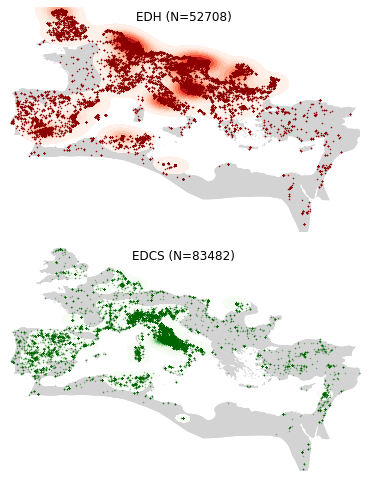

In [121]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[5.2, 7], tight_layout=True)

plt.rcParams['axes.titley'] = 1.0 
plt.rcParams['axes.titlepad'] = -14

pleiades_regions.plot(ax=ax1, color="lightgray")
gplt.kdeplot(EDHg, cmap='Reds', shade=True, ax=ax1) # , clip=EDHg.geometry,
EDHg.plot(ax=ax1, color="darkred", markersize=0.3)
ax1.set_axis_off()
ax1.set_xlim(-10, 41)
ax1.set_ylim(23, 55.5)
ax1.set_title("EDH (N={0})".format(len(EDHg)))

pleiades_regions.plot(ax=ax2, color="lightgray")
gplt.kdeplot(EDCSg, cmap='Greens', shade=True, ax=ax2) # , clip=EDHg.geometry,
EDCSg.plot(ax=ax2, alpha=0.4, color="darkgreen", markersize=0.3)
ax2.set_axis_off()
ax2.set_xlim(-10, 41)
ax2.set_ylim(23, 55.5)
ax2.set_title("EDCS (N={0})".format(len(EDCSg)))

In [122]:
fig.savefig("../figures/EDH-EDCS_spatial_distributions.eps", format="eps", dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Urban contexts

In [125]:
cities_pop = gpd.read_file("../data/roman_cities_pop.geojson")

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,5,1,NaN,NaN,NaN,NaN,1700.0,NaN,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,None,3,2,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,7,3,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,8,4,NaN,NaN,NaN,NaN,8209.0,NaN,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,NaN,None,8,5,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (22.35572 38.14795)


In [128]:
cities_pop.sort_values("pop_est", ascending=False, inplace=True)
cities_pop.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
991,Hanson2016_992,Roma,Rome,Italia (VII Etruria),Italy,1,43 B2,-700,NaN,Beloch 1886; Benario 1981; de Ligt 2012; Golvi...,1783.0,Fourteen Augustan regions,236,992,89.0,89.0,89.0,923406.0,923313.0,1.000101,POINT (12.48510 41.89278)
109,Hanson2016_110,Alexandria (Aegyptus),Alexandria,Aegyptus,Egypt,1,74 B2,-322,NaN,Beloch 1886; Bowman 2011; Cohen 2006; Humphrey...,972.0,Urban grid,30,110,3.0,3.0,3.0,410535.0,410502.0,1.000080,POINT (29.90373 31.19502)
179,Hanson2016_180,Lepcis Magna,Lebda,Africa Proconsularis,Libya,1,35 G2,-30,NaN,Bomgardner 2000; Golvin 1988; Humphrey 1986; L...,466.0,Ramparts,46,180,NaN,NaN,NaN,NaN,153722.0,NaN,POINT (14.29306 32.63833)
308,Hanson2016_309,Rhodus,Rhodes,Asia,Greece,3,60 G3,-408,NaN,Beloch 1886; Hansen 2006; Hansen and Nielsen 2...,412.0,Urban grid,17,309,NaN,NaN,NaN,NaN,130398.0,NaN,POINT (28.22701 36.44324)
1323,Hanson2016_1324,Antiochia (Syria),Antakya,Syria,Turkey,1,67 C4,-300,NaN,Boatwright 2000; Jones 1937; McEvedy 2011; Nel...,399.0,"Walls of Theodosius II, Justinian, and topography",33,1324,NaN,NaN,NaN,NaN,124930.0,NaN,POINT (36.16963 36.21017)


In [129]:
len(cities_pop)

1388

In [130]:
# total urban population
cities_pop["pop_est"].sum()

10159670.0

In [131]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Select Bibliography', 'Area',
       'Estimate Basis', 'num_of_structures', 'ID', 'level_0', 'Unnamed: 0_y',
       'index', 'pop_sample', 'pop_est', 'pop_diff', 'geometry'],
      dtype='object')

In [252]:
def get_city_type(pop_est):
    if pop_est >= 30000:
        return "big"
    else:
        if pop_est > 1000:
            return "middle"
        else: 
            return "minor"
cities_pop["city_type"] = cities_pop["pop_est"].apply(get_city_type)

In [254]:
# create two groups of cities
cities_big = cities_pop[cities_pop["city_type"] == "big"]
cities_middle = cities_pop[cities_pop["city_type"] =="middle"]
print("big cities (n={2}) - pop {0}, middle cities (n={3}) {1}".format(cities_big["pop_est"].sum(), cities_middle["pop_est"].sum(), len(cities_big), len(cities_rest)))

big cities (n=68) - pop 4641352.0, middle cities (n=690) 4942985.0


In [255]:
cities_minor = cities_pop[cities_pop["city_type"] == "minor"]
print(len(cities_minor), cities_minor["pop_est"].sum())

630 575333.0


In [256]:
# by default, buffer is calculated in degrees
# we need to reproject it to calculate buffer in meters

def buffer_in_meters(pt_latlng, city_type): #(lng, lat, area_ha, coef):
    proj_meters = pyproj.Proj(init='epsg:3035')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_meters = transform(project_to_meters, pt_latlng)
    if city_type == "minor":
        buffer_latlng == pt_latlng
    else:
        if city_type == "big":
            radius = 37000
        else:
            radius = 18500 
        buffer_meters = pt_meters.buffer(radius)
        buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [258]:
%%time
cities_big["geometry"] = cities_big.apply(lambda row: buffer_in_meters(row["geometry"], row["city_type"]), axis=1)

CPU times: user 27.1 s, sys: 464 ms, total: 27.6 s
Wall time: 27.6 s


In [261]:
%%time
cities_middle["geometry"] = cities_middle.apply(lambda row: buffer_in_meters(row["geometry"], row["city_type"]), axis=1)

CPU times: user 4min 33s, sys: 4.78 s, total: 4min 38s
Wall time: 4min 38s


(23.0, 55.5)

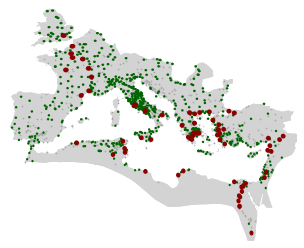

In [265]:
fig, ax = plt.subplots(figsize=[5.2, 5])
pleiades_regions.plot(ax=ax, color="lightgray")
cities_minor.plot(ax=ax, color="darkgrey", markersize=0.5)
cities_middle.plot(ax=ax, color="darkgreen")
cities_big.plot(ax=ax, color="darkred")
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)

In [82]:
### some inspiration from here
# https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give

In [157]:
cities_big_multipolygon = cities_big["geometry"].unary_union
cities_middle_multipolygon = cities_middle["geometry"].unary_union

In [159]:
%%time
# for each inscription, decide whether it is in the multipolygon or not 
edh_big_cities_series = EDHg.within(cities_big_multipolygon)
edh_middle_cities_series = EDHg.within(cities_middle_multipolygon)

# working df with the same length as EDH
in_cities_df = pd.DataFrame([edh_big_cities_series, edh_middle_cities_series]).T
in_cities_df.columns = ["in_big", "in_middle"]
in_cities_df.head()

CPU times: user 3min 15s, sys: 0 ns, total: 3min 15s
Wall time: 3min 15s


,in_big,in_middle
1,True,True
2,False,True
3,False,False
4,True,True
5,False,False


In [160]:
%%time
# for each inscription, decide whether it is in the multipolygon or not 
edcs_big_cities_series = EDCSg.within(cities_big_multipolygon)
edcs_middle_cities_series = EDCSg.within(cities_middle_multipolygon)

# working df with the same length as EDCS
in_cities_df_edcs = pd.DataFrame([edcs_big_cities_series, edcs_middle_cities_series]).T
in_cities_df_edcs.columns = ["in_big", "in_middle"]
in_cities_df_edcs.head()

CPU times: user 5min 14s, sys: 7.13 ms, total: 5min 14s
Wall time: 5min 14s


,in_big,in_middle
1590,True,False
2061,False,False
2063,False,False
2066,False,False
2070,False,False


In [161]:
# working df 
def get_big_middle_rest(row):
    value = "rest"
    if row["in_middle"]:
        value = "middle"
    if row["in_big"]:
        value = "big"
    return value

EDHg["urban_context"] = in_cities_df.apply(lambda row: get_big_middle_rest(row), axis=1)
EDCSg["urban_context"] = in_cities_df_edcs.apply(lambda row: get_big_middle_rest(row), axis=1)

In [162]:
# for future usage elsewhere, let's add this to the original dataset and upload it to the sciencedata
#urban_contexts_edh_dict = dict(zip(EDHg["id"].tolist(), EDHg["urban_context"].tolist()))
#sddk.write_file("SDAM_data/social_diversity/urban_contexts_edh_dict.json", urban_contexts_edh_dict, conf)

#urban_contexts_edcs_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["urban_context"].tolist()))
#sddk.write_file("SDAM_data/social_diversity/urban_contexts_edcs_dict.json", urban_contexts_edcs_dict, conf)
#def get_urban_context(id, dataset_name):
#    if dataset_name == "EDH":
#        try: return urban_contexts_edh_dict[id]
#        except: return "unknown"
#    if dataset_name == "EDCS":
#        try: return urban_contexts_edcs_dict[id]
#        except: return "unknown"
#EDHg["urban_context"] = EDHg["id"].apply(lambda x: get_urban_context(x, "EDH"))
#EDCSg["urban_context"] = EDCSg["EDCS-ID"].apply(lambda x: get_urban_context(x, "EDCS"))

In [163]:
print("EDH inscriptions in big cities: ", len(EDHg[EDHg["urban_context"]=="big"]))
print("EDH inscriptionslen in middle cities: ", len(EDHg[EDHg["urban_context"]=="middle"]))
print("EDH inscriptions - rest: ", len(EDHg[EDHg["urban_context"]=="rest"]))

EDH inscriptions in big cities:  3850
EDH inscriptionslen in middle cities:  23733
EDH inscriptions - rest:  25125


In [164]:
print("EDCS inscriptions in big cities: ", len(EDCSg[EDCSg["urban_context"]=="big"]))
print("EDCS inscriptionslen in middle cities: ", len(EDCSg[EDCSg["urban_context"]=="middle"]))
print("EDCS inscriptions - rest: ", len(EDCSg[EDCSg["urban_context"]=="rest"]))

EDCS inscriptions in big cities:  41792
EDCS inscriptionslen in middle cities:  31939
EDCS inscriptions - rest:  9751


In [446]:
sddk.write_file("SDAM_data/social_diversity/EDH_filtered.json", pd.DataFrame(EDHg.drop("geometry", axis=1)), conf)
sddk.write_file("SDAM_data/social_diversity/EDCS_filtered.json", pd.DataFrame(EDCSg.drop("geometry", axis=1)), conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_filtered.json"


In [173]:
rome_polygon = cities_big.loc[cities_big["Modern Toponym"]=="Rome"]["geometry"].tolist()[0]

In [183]:
%%time
EDHg["within_rome"] = EDHg.within(rome_polygon)
EDCSg["within_rome"] = EDCSg.within(rome_polygon)

print(len(EDHg[EDHg["within_rome"]==True]))
print(len(EDCSg[EDCSg["within_rome"]==True]))

2628
38924
CPU times: user 744 ms, sys: 0 ns, total: 744 ms
Wall time: 742 ms


In [266]:
EDCSg_rome = EDCSg[EDCSg["within_rome"]==True]
EDCSg_rome["province"].unique().tolist()

['Etruria / Regio VII',
 'Latium et Campania / Regio I',
 'Roma',
 'Samnium / Regio IV']

In [267]:
len(EDCSg_rome[EDCSg_rome["province"]=="Roma"])

35427

<AxesSubplot:>

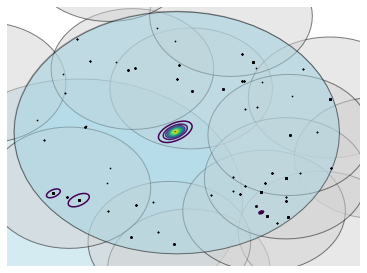

In [213]:
fig, ax = plt.subplots(figsize=[5.2, 5.2], tight_layout=True)

#pleiades_regions.plot(ax=ax1, color="lightgray")
#gplt.kdeplot(EDHg, cmap='Reds', shade=True, ax=ax1) # , clip=EDHg.geometry,
#EDHg.plot(ax=ax1, color="darkred", markersize=0.3)
#ax1.set_axis_off()
#ax1.set_xlim(-10, 41)
#ax1.set_ylim(23, 55.5)
#ax1.set_title("EDH (N={0})".format(len(EDHg)))


ax.set_axis_off()
cities_big[cities_big.intersects(rome_polygon)].plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5)
cities_middle[cities_middle.intersects(rome_polygon)].plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5)

cities_big.loc[cities_big["Modern Toponym"]=="Rome"].plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5)
# for anotations: 
# cities_rome = cities_pop[(cities_pop["Ancient Toponym"].isin(nearest_cities["city"].unique().tolist())) & (cities_pop["pop_est"] > 1000)]
#for x, y, label in zip(cities_rome.geometry.x, cities_rome.geometry.y, cities_rome["Ancient Toponym"]):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
#gplt.kdeplot(EDCSg_rome, Shade=True, ax=ax)

gplt.kdeplot(EDCSg_rome, Shade=True, ax=ax)
EDCSg_rome.plot(color="black", markersize=0.5, ax=ax)

# Nearest cities

In [283]:
def ckdnearest(inscriptions, cities):
    cities = cities[['Ancient Toponym', "ID", "pop_est", 'geometry', "city_type"]]
    cities.rename(columns={"Ancient Toponym" : "nearest_city", "city_type": "nearest_city_type", "pop_est" : "city_pop_est", "ID" : "city_id_hanson"}, inplace=True)
    nA = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = cities.iloc[idx].rename(columns={"geometry": "city_geometry"}).reset_index(drop=True)
    gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='nearest_city_dist')
        ], 
        axis=1)
    return gdf

#ckdnearest(gpd1, gpd2)

In [268]:
# nearest cities in the Rome neighborhood
nearest_cities = ckdnearest(EDCSg_rome, cities_pop)
nearest_cities.groupby("city").size()

city
Aricia             332
Baccanae             5
Bovillae            25
Capena               1
Castrimoenium      122
Fidenae            110
Fregenae            23
Gabii               44
Labicum             10
Lanuvium            75
Lavinium            78
Nomentum           125
Ostia             1632
Portus             538
Roma             35427
Tibur              220
Tusculum           109
Veii                46
Vitellia             2
dtype: int64

In [248]:
# nearest cities in the Rome neighborhood
nearest_cities = ckdnearest(EDCSg_rome, cities_pop)
nearest_cities.groupby("city").size()

city
Aricia             332
Baccanae             5
Bovillae            25
Capena               1
Castrimoenium      122
Fidenae            110
Fregenae            23
Gabii               44
Labicum             10
Lanuvium            75
Lavinium            78
Nomentum           125
Ostia             1632
Portus             538
Roma             35427
Tibur              220
Tusculum           109
Veii                46
Vitellia             2
dtype: int64

In [294]:
%%time
EDCSg = ckdnearest(EDCSg, cities_pop)

CPU times: user 1.37 s, sys: 3.95 ms, total: 1.37 s
Wall time: 1.37 s


In [297]:
print(len(EDCSg[EDCSg["nearest_city_type"]=="big"]))
print(len(EDCSg[EDCSg["nearest_city_type"]=="middle"]))
print(len(EDCSg[EDCSg["nearest_city_type"]=="minor"]))

38311
37099
8072


In [298]:
%%time
EDHg = ckdnearest(EDHg, cities_pop)

CPU times: user 1.09 s, sys: 7.95 ms, total: 1.1 s
Wall time: 1.1 s


In [299]:
print(len(EDHg[EDHg["nearest_city_type"]=="big"]))
print(len(EDHg[EDHg["nearest_city_type"]=="middle"]))
print(len(EDHg[EDHg["nearest_city_type"]=="minor"]))

3659
35388
13661
